# SMS Spam Classification – Notebook corregido
Este cuaderno soluciona los errores de forma y vacíos que provocaban fallos en el entrenamiento.

## 0. Descarga y limpieza del dataset

In [1]:
import pandas as pd, numpy as np, tensorflow as tf
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Descarga (solo la primera vez)
!wget -q -O spam.csv https://raw.githubusercontent.com/javierherrera1996/IntroMachineLearning/refs/heads/main/TercerCorte/spam.csv

# Cargar CSV con codificación correcta y quedarnos con columnas relevantes
df = (pd.read_csv("spam.csv", encoding="ISO-8859-1")
        .rename(columns={'v1':'label', 'v2':'text'})
        [['label','text']])

# Eliminar filas con texto vacío o nulo
df = df.dropna(subset=['text'])
df = df[df['text'].str.strip().astype(bool)]

df.head()

,label,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


## 1. Configuración y seed

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
np.random.seed(42)
tf.random.set_seed(42)


## 2. División Train/Test

In [3]:
y = df['label'].map({'ham':0,'spam':1})
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], y, test_size=0.2, stratify=y, random_state=42)

print(len(X_train),"train |", len(X_test),"test")


4457 train | 1115 test


## 3. Vectorización de texto con manejo seguro de dimensiones

In [4]:
MAX_TOKENS, MAX_LEN = 10000, 100
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_TOKENS,
    output_sequence_length=MAX_LEN,
    standardize="lower_and_strip_punctuation")
vectorizer.adapt(X_train.values)

def to_tensor(txt, label):
    txt = tf.expand_dims(txt, -1)          # (1,)
    seq = tf.squeeze(vectorizer(txt), axis=0) # (MAX_LEN,)
    return seq, label

batch = 32
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values, y_train.values))
            .shuffle(10000)
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))
test_ds  = (tf.data.Dataset.from_tensor_slices((X_test.values, y_test.values))
            .map(to_tensor, num_parallel_calls=AUTOTUNE)
            .batch(batch)
            .prefetch(AUTOTUNE))


## 4. Definición y entrenamiento del modelo

In [5]:
EMBED_DIM = 16
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_TOKENS, EMBED_DIM, input_length=MAX_LEN),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_ds, validation_data=test_ds, epochs=5)


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


140/140 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - accuracy: 0.8423 - loss: 0.4868 - val_accuracy: 0.8664 - val_loss: 0.3707
Epoch 2/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8743 - loss: 0.3637 - val_accuracy: 0.8664 - val_loss: 0.3653
Epoch 3/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8595 - loss: 0.3818 - val_accuracy: 0.8664 - val_loss: 0.3584
Epoch 4/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8662 - loss: 0.3668 - val_accuracy: 0.8664 - val_loss: 0.3514
Epoch 5/5
140/140 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.8670 - loss: 0.3498 - val_accuracy: 0.8664 - val_loss: 0.3343


## 5. Curva de aprendizaje

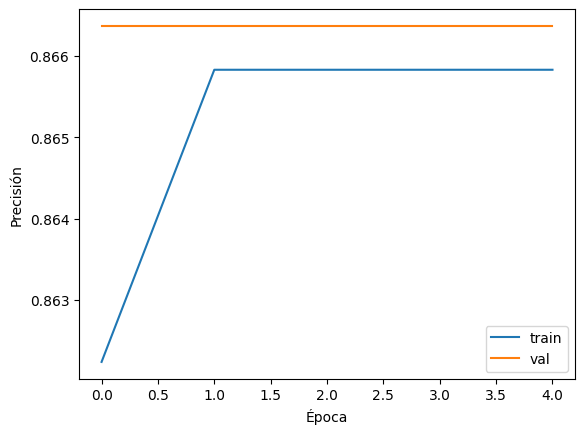

In [6]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='val')
plt.legend(); plt.xlabel('Época'); plt.ylabel('Precisión'); plt.show()


## 6. Evaluación

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


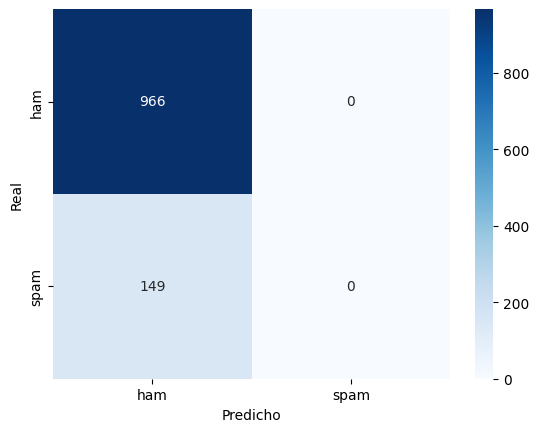

AUC: 0.9592035238373143


In [7]:
y_prob = model.predict(test_ds).ravel()
y_pred = (y_prob > 0.4).astype(int)   # Umbral 0.4 para mejorar recall spam
y_true = y_test.values

print(classification_report(y_true, y_pred, target_names=['ham','spam']))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['ham','spam'], yticklabels=['ham','spam'])
plt.xlabel('Predicho'); plt.ylabel('Real'); plt.show()

fpr,tpr,_ = roc_curve(y_true, y_prob)
print("AUC:", auc(fpr,tpr))


## 7. Próximos pasos
- Aumentar `epochs` si no hay sobreajuste.
- Probar `class_weight={0:1,1:2}` en `model.fit`.
- Cambiar la arquitectura a `Bidirectional(LSTM(32))` para capturar contexto.
- Usar embeddings preentrenados (GloVe) para menos datos.